# RL and Advanced DL: Домашнее задание 3

In [1]:
import gc
import os
from copy import deepcopy
from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:

Датасет можно скачать [здесь](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz) (и во многих других местах, должно быть ~29 мегабайт).

В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно [Isola et al., 2016](https://arxiv.org/pdf/1611.07004.pdf):


In [2]:
!wget -nc http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

--2021-12-20 07:51:41--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  2.44MB/s    in 8.7s    

2021-12-20 07:51:49 (3.31 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [3]:
!tar -xf facades.tar.gz

In [4]:
class PixToPixDataset(Dataset):
    def __init__(self, path_dir):
        super().__init__()
        self.images = [os.path.join(path_dir, path) for path in os.listdir(path_dir)]
        self.transforms = torchvision.transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    @staticmethod
    def _split_image(img):
        image_array = np.array(img)
        split_line = img.width // 2
        output_img = image_array[:, split_line:]
        input_img = image_array[:, :split_line]
        
        return output_img, input_img
        
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
        output_img, input_img = self._split_image(img)
        output_img = self.transforms(output_img)
        input_img = self.transforms(input_img)
        
        return output_img, input_img

[U-Net: Semantic segmentation with PyTorch](https://github.com/milesial/Pytorch-UNet/tree/e1a69e7c6ce18edd47271b01e4aabc03b436753d#u-net-semantic-segmentation-with-pytorch)

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        factor = 2

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5), stride=1, padding=1, bias=False)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            ConvBlock(2 * in_channels, 16, batch_norm=False),
            ConvBlock(16, 32),
            nn.Conv2d(32, 3, 2, 1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(46875, 2)

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        
        x = self.linear_layers(x)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x[:,0]

In [7]:
BATCH_SIZE = 6
train_dataset = PixToPixDataset('facades/train/')
test_dataset = PixToPixDataset('facades/test/')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [25]:
revert_image = torchvision.transforms.ToPILImage()


def show_eval_image(g_model, figsize=(3, 9), img_id=8):
        in_i, out_i = test_dataset[img_id]
        fig, ax = plt.subplots(1, 3)
        fig.set_figheight(figsize[0])
        fig.set_figwidth(figsize[1])
        
        ax[0].imshow(revert_image(in_i))
        ax[0].axis('off')
        ax[1].imshow(revert_image(out_i))
        ax[1].axis('off')
        ax[2].imshow(revert_image(g_model(in_i.unsqueeze(0).to(DEVICE)).squeeze()))
        ax[2].axis('off')
        plt.show()

        
def train(g_model, g_opt, d_model, d_opt, alpha=10, n_epoch=10, device=DEVICE):
    for i, epoch in enumerate(range(n_epoch)):
            epoch_g_losses = []
            epoch_d_losses = []
            valid = torch.ones(BATCH_SIZE).to(device)
            false = torch.zeros(BATCH_SIZE).to(device)

            for input_tensor, output_tensor in tqdm(train_dataloader, total=len(train_dataloader)):
                input_tensor = input_tensor.to(device)
                output_tensor = output_tensor.to(device)

                # generator
                g_opt.zero_grad()
                
                d_model.eval()
                x_gen = g_model(input_tensor)
                pred_fake = torch.sigmoid(d_model(torch.cat([input_tensor, x_gen], dim=1))[:,0])
                g_loss = alpha * F.l1_loss(x_gen, output_tensor) + F.binary_cross_entropy(pred_fake, valid)
                g_loss.backward()
                g_opt.step()

                # discriminator
                d_opt.zero_grad()
                
                d_model.train()
                pred_fake = torch.sigmoid(d_model(torch.cat([input_tensor, x_gen.detach()], dim=1))[:,0])
                pred_true = torch.sigmoid(d_model(torch.cat([input_tensor, output_tensor], dim=1))[:,0])
                d_loss = F.binary_cross_entropy(pred_fake, false) + F.binary_cross_entropy(pred_true, valid) # bce_fake + bce_true
                d_loss.backward()
                d_opt.step()

                epoch_g_losses.append(g_loss.item())
                epoch_d_losses.append(d_loss.item())
                
            show_eval_image(g_model)
            print(f"Epoch {i + 1}/{n_epoch}, train losses: gen {np.mean(epoch_g_losses):.4f} / disc {np.mean(epoch_d_losses):.4f}")


In [26]:
out_dim = 3

generator = UNet(n_channels=3, n_classes=out_dim).to(DEVICE)

discriminator = torchvision.models.resnet18(pretrained=True)
discriminator.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = discriminator.fc.in_features
discriminator.fc = nn.Linear(num_ftrs, 2)
discriminator = discriminator.to(DEVICE)

opt_g = torch.optim.Adam(generator.parameters(), lr=7e-4)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


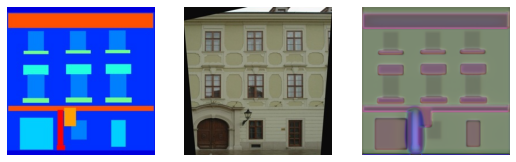

Epoch 1/15, train losses: gen 4.4622 / disc 0.8490


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


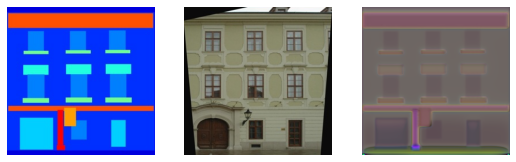

Epoch 2/15, train losses: gen 3.8705 / disc 0.2169


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


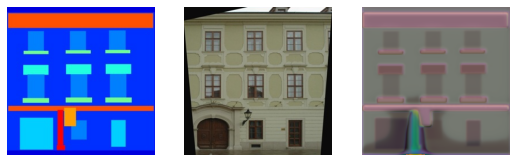

Epoch 3/15, train losses: gen 4.1273 / disc 0.4158


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


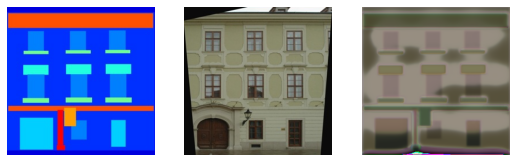

Epoch 4/15, train losses: gen 3.8840 / disc 0.1768


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


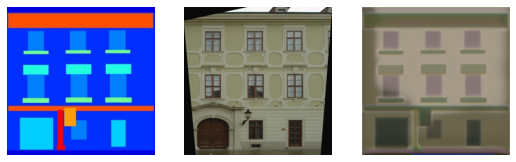

Epoch 5/15, train losses: gen 4.1678 / disc 0.0114


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


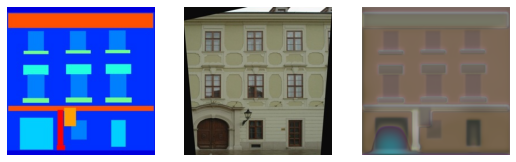

Epoch 6/15, train losses: gen 4.2077 / disc 0.0070


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


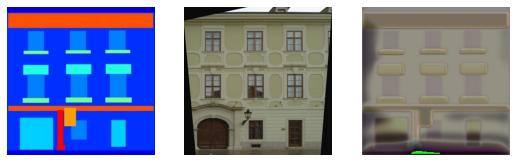

Epoch 7/15, train losses: gen 4.2563 / disc 0.2638


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


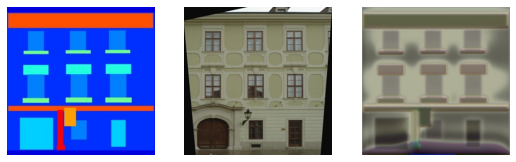

Epoch 8/15, train losses: gen 3.7449 / disc 0.5933


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


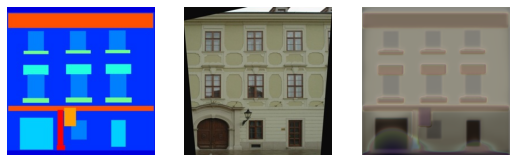

Epoch 9/15, train losses: gen 3.3907 / disc 1.1062


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


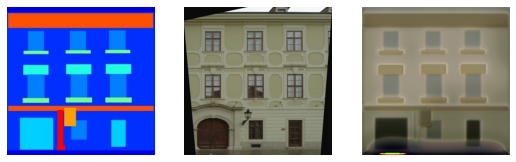

Epoch 10/15, train losses: gen 2.8899 / disc 0.2154


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


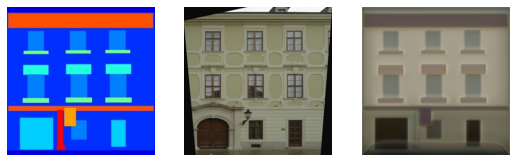

Epoch 11/15, train losses: gen 2.7904 / disc 0.0203


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


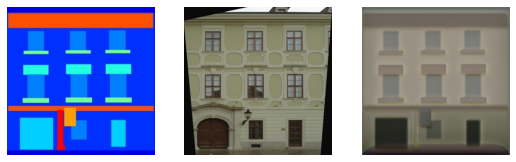

Epoch 12/15, train losses: gen 2.7673 / disc 0.0096


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


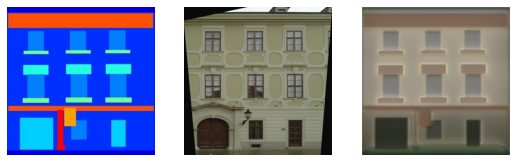

Epoch 13/15, train losses: gen 2.7741 / disc 0.0058


100%|██████████| 66/66 [01:35<00:00,  1.44s/it]


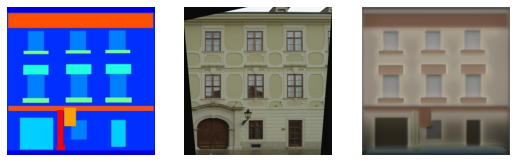

Epoch 14/15, train losses: gen 2.7873 / disc 0.0047


100%|██████████| 66/66 [01:35<00:00,  1.45s/it]


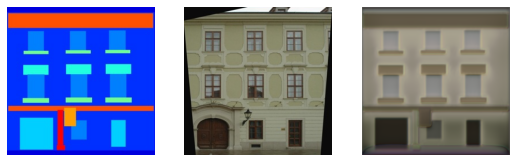

Epoch 15/15, train losses: gen 2.7762 / disc 0.0034


In [27]:
train(generator, opt_g, discriminator, opt_d, alpha=15, n_epoch=15)

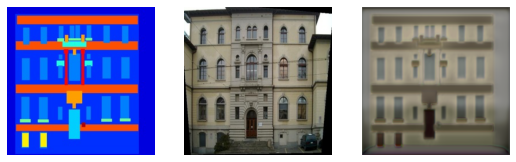

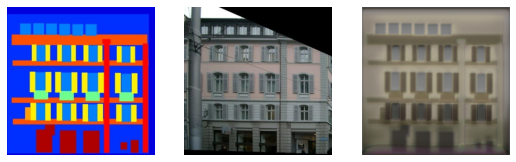

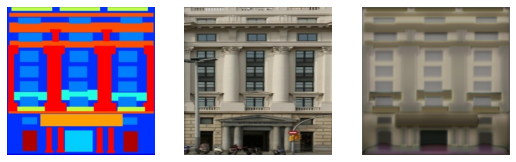

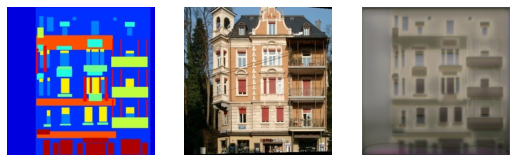

In [28]:
show_eval_image(generator, img_id=11)
show_eval_image(generator, img_id=23)
show_eval_image(generator, img_id=30)
show_eval_image(generator, img_id=39)

## Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно [Zhu et al., 2017](https://arxiv.org/pdf/1703.10593.pdf):

В качестве опционального задания за немного дополнительных баллов здесь предлагаю найти дополнительные данные такого рода (фасады и их карты сегментации) и улучшить качество переноса стиля за счёт обучения на датасете побольше. Данные, скорее всего, будут unpaired, поэтому эта часть скорее релевантна CycleGAN.


In [32]:
def show_eval_cycle_image(g_model_1, g_model_2, figsize=(3, 12), img_id=8):
        in_i, out_i = test_dataset[img_id]
        fig, ax = plt.subplots(1, 4)
        fig.set_figheight(figsize[0])
        fig.set_figwidth(figsize[1])
        
        ax[0].imshow(revert_image(in_i))
        ax[0].axis('off')
        ax[1].imshow(revert_image(g_model_2(out_i.unsqueeze(0).to(DEVICE)).squeeze()))
        ax[1].axis('off')
        ax[2].imshow(revert_image(out_i))
        ax[2].axis('off')
        ax[3].imshow(revert_image(g_model_1(in_i.unsqueeze(0).to(DEVICE)).squeeze()))
        ax[3].axis('off')
        plt.show()


def train_cycle(
    g_model_1, g_model_2, g_opt_1, g_opt_2,
    d_model_1, d_model_2, d_opt_1, d_opt_2,
    alpha=10, n_epoch=10, device=DEVICE
):
    for i, epoch in enumerate(range(n_epoch)):
            epoch_g_losses = []
            epoch_d_losses = []
            valid = torch.ones(BATCH_SIZE).to(device)
            false = torch.zeros(BATCH_SIZE).to(device)

            for input_tensor, output_tensor in tqdm(train_dataloader, total=len(train_dataloader)):
                input_tensor = input_tensor.to(device)
                output_tensor = output_tensor.to(device)

                # generator
                d_model_1.eval()
                d_model_2.eval()
                g_opt_1.zero_grad()
                g_opt_2.zero_grad()

                out_gen = g_model_1(input_tensor)
                in_gen_gen = g_model_2(out_gen)
                in_gen = g_model_2(output_tensor)
                out_gen_gen = g_model_1(in_gen)
                
                pred_fake_out = torch.sigmoid(d_model_1(torch.cat([input_tensor, out_gen], dim=1))[:,0])
                pred_fake_in = torch.sigmoid(d_model_2(torch.cat([in_gen, output_tensor], dim=1))[:,0])
                
                loss_gen = F.l1_loss(in_gen_gen, input_tensor) + F.l1_loss(out_gen_gen, output_tensor)
                loss_disc = F.binary_cross_entropy(pred_fake_out, valid) + F.binary_cross_entropy(pred_fake_in, valid)
                
                g_loss = alpha * loss_gen + loss_disc
                g_loss.backward()
                g_opt_1.step()
                g_opt_2.step()
                
                # discriminator
                d_model_1.train()
                d_model_2.train()
                d_opt_1.zero_grad()
                d_opt_2.zero_grad()
                
                pred_true_out = torch.sigmoid(d_model_1(torch.cat([input_tensor, output_tensor], dim=1))[:,0])
                pred_true_in = torch.sigmoid(d_model_2(torch.cat([input_tensor, output_tensor], dim=1))[:,0])
                pred_false_out = torch.sigmoid(d_model_1(torch.cat([input_tensor, out_gen.detach()], dim=1))[:,0])
                pred_false_in = torch.sigmoid(d_model_2(torch.cat([in_gen.detach(), output_tensor], dim=1))[:,0])
                
                d_loss = (
                    F.binary_cross_entropy(pred_false_out, false) + F.binary_cross_entropy(pred_false_in, false)
                    + F.binary_cross_entropy(pred_true_out, valid) + F.binary_cross_entropy(pred_true_in, valid)
                )
                d_loss.backward()
                d_opt_1.step()
                d_opt_2.step()

                epoch_g_losses.append(g_loss.item())
                epoch_d_losses.append(d_loss.item())

            show_eval_cycle_image(g_model_1, g_model_2)
            print(f"Epoch {i + 1}/{n_epoch}, train losses: gen {np.mean(epoch_g_losses):.4f} / disc {np.mean(epoch_d_losses):.4f}")    



In [42]:
discriminator = torchvision.models.resnet18(pretrained=True)
discriminator.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = discriminator.fc.in_features
discriminator.fc = nn.Linear(num_ftrs, 2)

gen_1 = UNet(n_channels=3, n_classes=out_dim).to(DEVICE)
gen_2 = UNet(n_channels=3, n_classes=out_dim).to(DEVICE)
disc_1 = deepcopy(discriminator).to(DEVICE)
disc_2 = deepcopy(discriminator).to(DEVICE)

opt_g_1 = torch.optim.Adam(gen_1.parameters(), lr=7e-4)
opt_g_2 = torch.optim.Adam(gen_2.parameters(), lr=7e-4)
opt_d_1 = torch.optim.Adam(disc_1.parameters(), lr=1e-3)
opt_d_2 = torch.optim.Adam(disc_2.parameters(), lr=1e-3)

In [43]:
generator = None
discriminator = None
torch.cuda.empty_cache()
gc.collect()

97

100%|██████████| 66/66 [05:19<00:00,  4.85s/it]


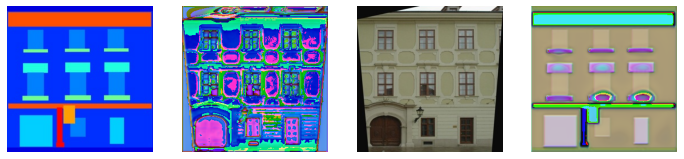

Epoch 1/10, train losses: gen 6.1342 / disc 1.1757


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


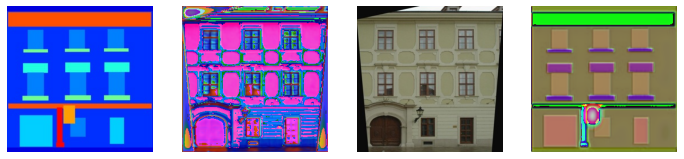

Epoch 2/10, train losses: gen 3.9861 / disc 0.0611


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


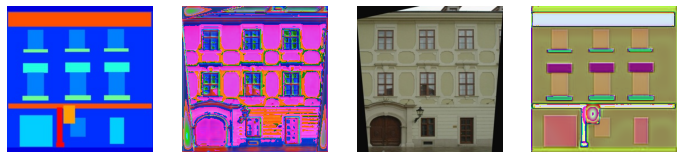

Epoch 3/10, train losses: gen 3.5811 / disc 0.0151


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


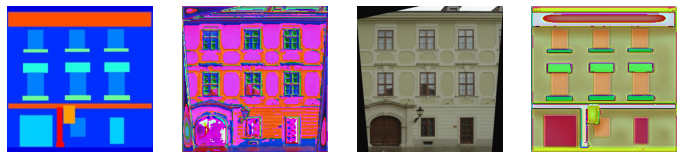

Epoch 4/10, train losses: gen 3.4649 / disc 0.0089


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


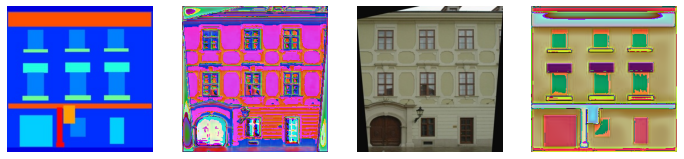

Epoch 5/10, train losses: gen 3.4611 / disc 0.0060


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


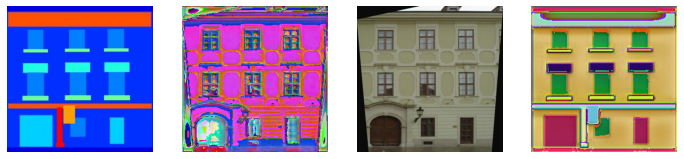

Epoch 6/10, train losses: gen 3.6009 / disc 0.0045


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


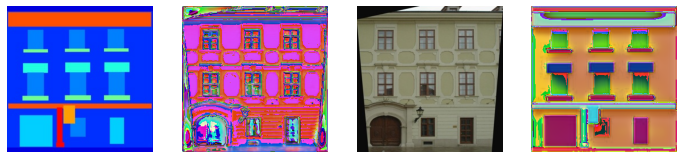

Epoch 7/10, train losses: gen 3.5698 / disc 0.0035


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


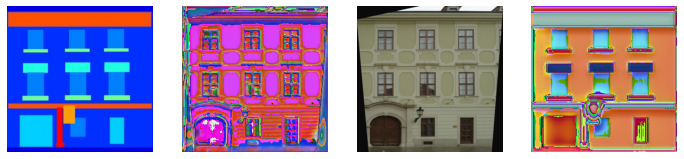

Epoch 8/10, train losses: gen 3.6912 / disc 0.0148


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


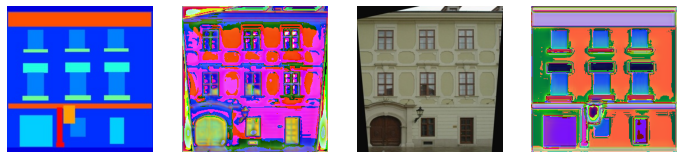

Epoch 9/10, train losses: gen 6.0198 / disc 0.7757


100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


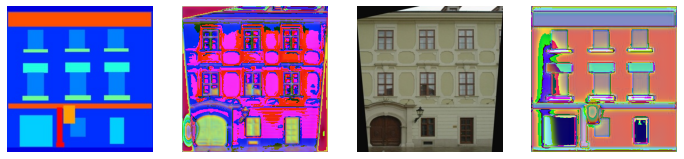

Epoch 10/10, train losses: gen 13.6069 / disc 0.3015


In [44]:
train_cycle(gen_1, gen_2, opt_g_1, opt_g_2, disc_1, disc_2, opt_d_1, opt_d_2, alpha=15)

100%|██████████| 66/66 [05:19<00:00,  4.84s/it]


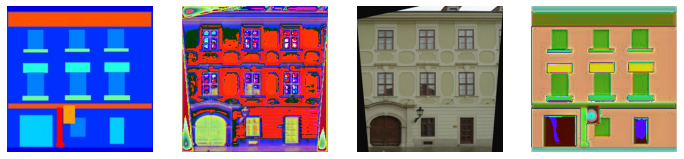

Epoch 1/10, train losses: gen 0.8880 / disc 0.0024


100%|██████████| 66/66 [05:20<00:00,  4.86s/it]


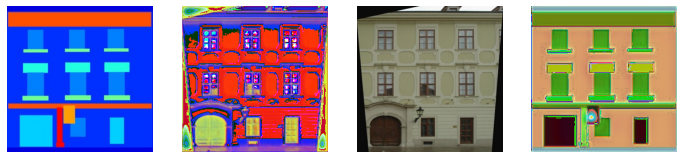

Epoch 2/10, train losses: gen 0.8785 / disc 0.0021


  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
train_cycle(gen_1, gen_2, opt_g_1, opt_g_2, disc_1, disc_2, opt_d_1, opt_d_2, alpha=10)